In [214]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"
!pip install yfinance;

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# setnng the theme
sns.set_theme(context="notebook", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [8, 6]})

Simulating stock prices using geometric Brownian motion

In [222]:
#import libraries
import numpy as np
import pandas as pd
import yfinance as yf

In [224]:
#downloading the data
df = yf.download("AAPL", start = "2022-01-01", end = "2023-12-31")
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700
2023-12-28,194.139999,194.660004,193.169998,193.580002,192.848221,34049900
2023-12-29,193.899994,194.399994,191.729996,192.529999,191.802185,42628800


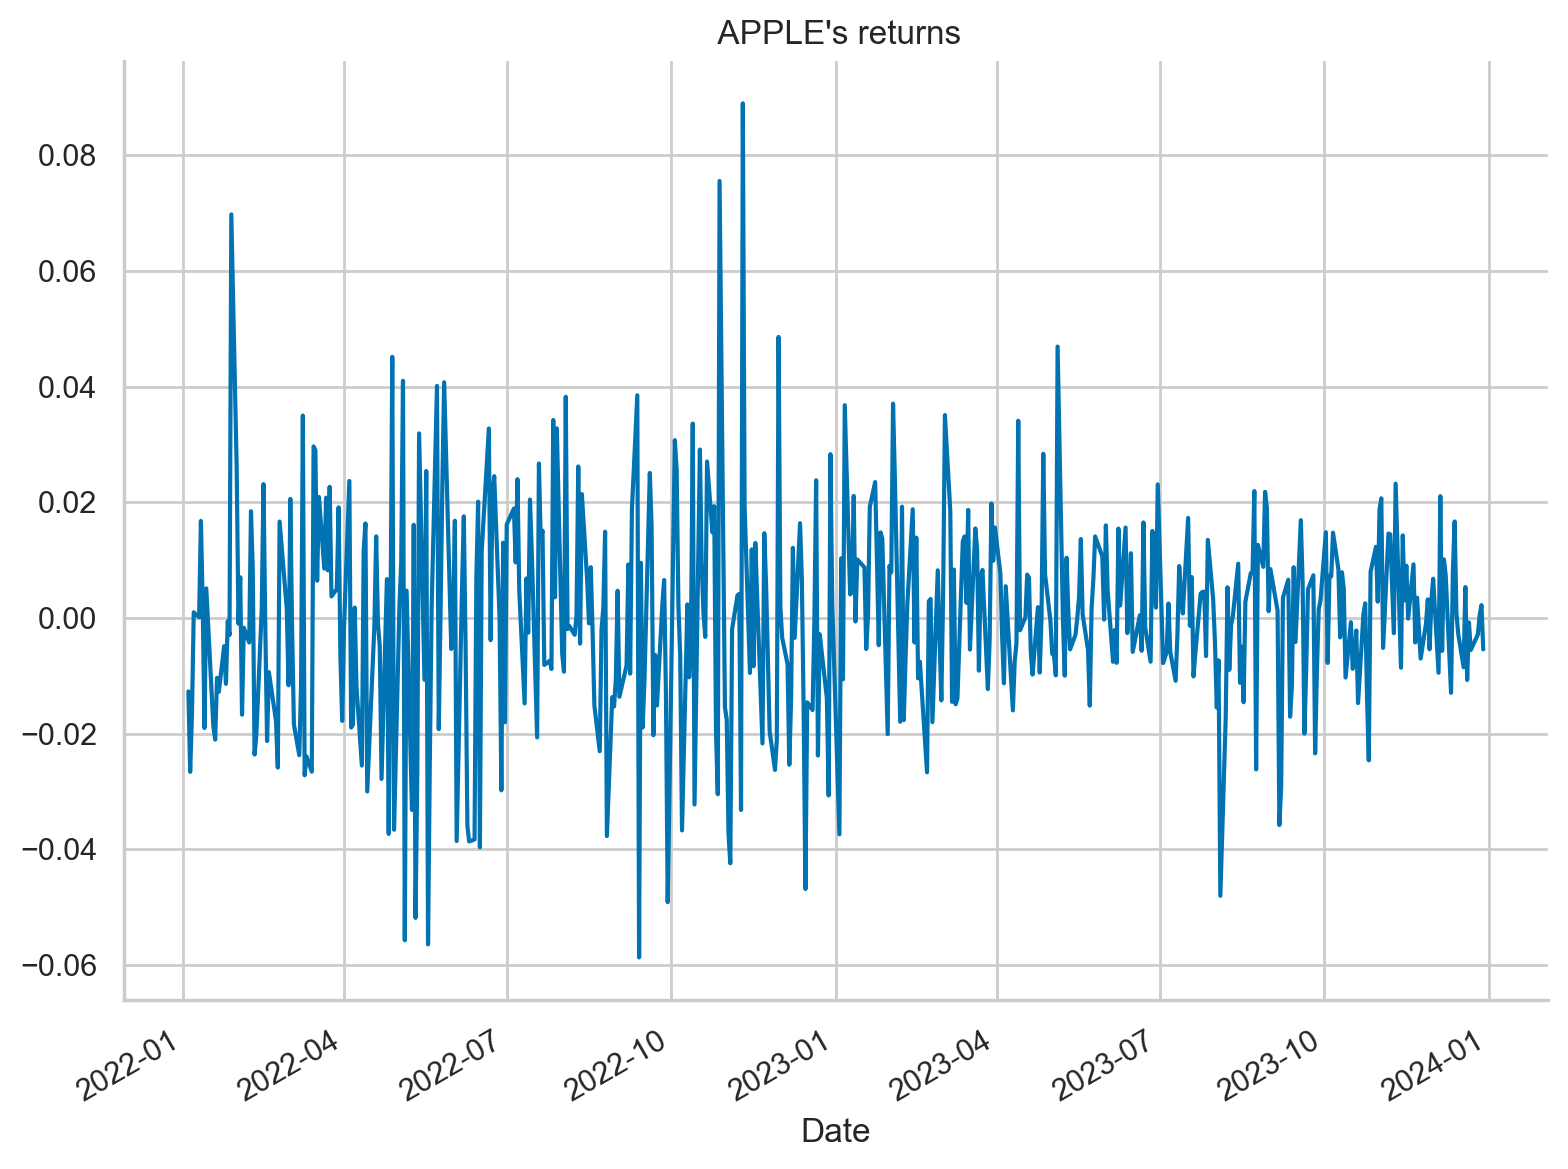

In [226]:
#plot returns
returns = df["Adj Close"].pct_change().dropna()
returns.plot(title=" APPLE's returns")
sns.despine() #for cleaner visualization
plt.tight_layout()

In [228]:
print(f"Average return: {100 * returns.mean():.2f}%")

Average return: 0.03%


In [230]:
#split data into training and test sets
train = returns["2022"]
test = returns["2023"]

#parameters of the simulation
T = len(test)
N = len(test)
S_0 = df.loc[train.index[-1],"Adj Close"] #access value of last closing price 
print (S_0)
N_SIM = 100
mu = train.mean() #training data mean
sigma = train.std() #training data standard deviation
print (mu,sigma)


128.71932983398438
-0.0010735006920478036 0.022471300524513606


In [232]:
#define function for running the simulation
def simulate_geobrowmot(s_0,mu,sigma,n_sims,T,N,random_seed=42):
    """"
    s_0 : float, Initial stock price
    mu : float,  Drift coefficient
    sigma : float, Diffusion coefficient
    n_sims : int, Number of simulations paths
    dt : float, Time increment
    T : float, Length of the forecast horizon, same unit as dt
    N : int, Number of time increments in the forecast horizon
    random_seed : int, Random seed for reproducibility
    
    S_t : np.ndarray, Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    """
    
    np.random.seed(random_seed) #ensuring random number generation is reproducible
    dt = T/N
    dW = np.random.normal(scale =np.sqrt(dt), size = (n_sims,N)) #generate matrix of random numbers with simulations as rows and time as column
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N) #generate a linearly spaced array
    time_steps = np.broadcast_to(time_step, (n_sims, N)) #time_step array is broadcasted to a specified shape
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W) #calcuates the stock price at each time t based on Geometrical Brownian Motion
    S_t = np.insert(S_t, 0, s_0, axis=1) #insert initial stock price at the start of each path
    
    return S_t

In [234]:
#run simulations and store the resule in a dataframe
gbm_sim = simulate_geobrowmot(S_0,mu,sigma, N_SIM,T,N)
sim_df = pd.DataFrame(np.transpose(gbm_sim),index=train.index[-1:].union(test.index))

In [236]:
# create a dataframe with avg value at each time and actual stock price
res_df = sim_df.mean(axis=1).to_frame()
res_df = res_df.join(df["Adj Close"])
res_df.columns = ["simulation_average", "adj_close_price"]
res_df.head()

,simulation_average,adj_close_price
Date,,
2022-12-30,128.719330,128.719330
2023-01-03,129.226643,123.904633
2023-01-04,129.131217,125.182610
2023-01-05,128.983696,123.855110
2023-01-06,128.922629,128.412231


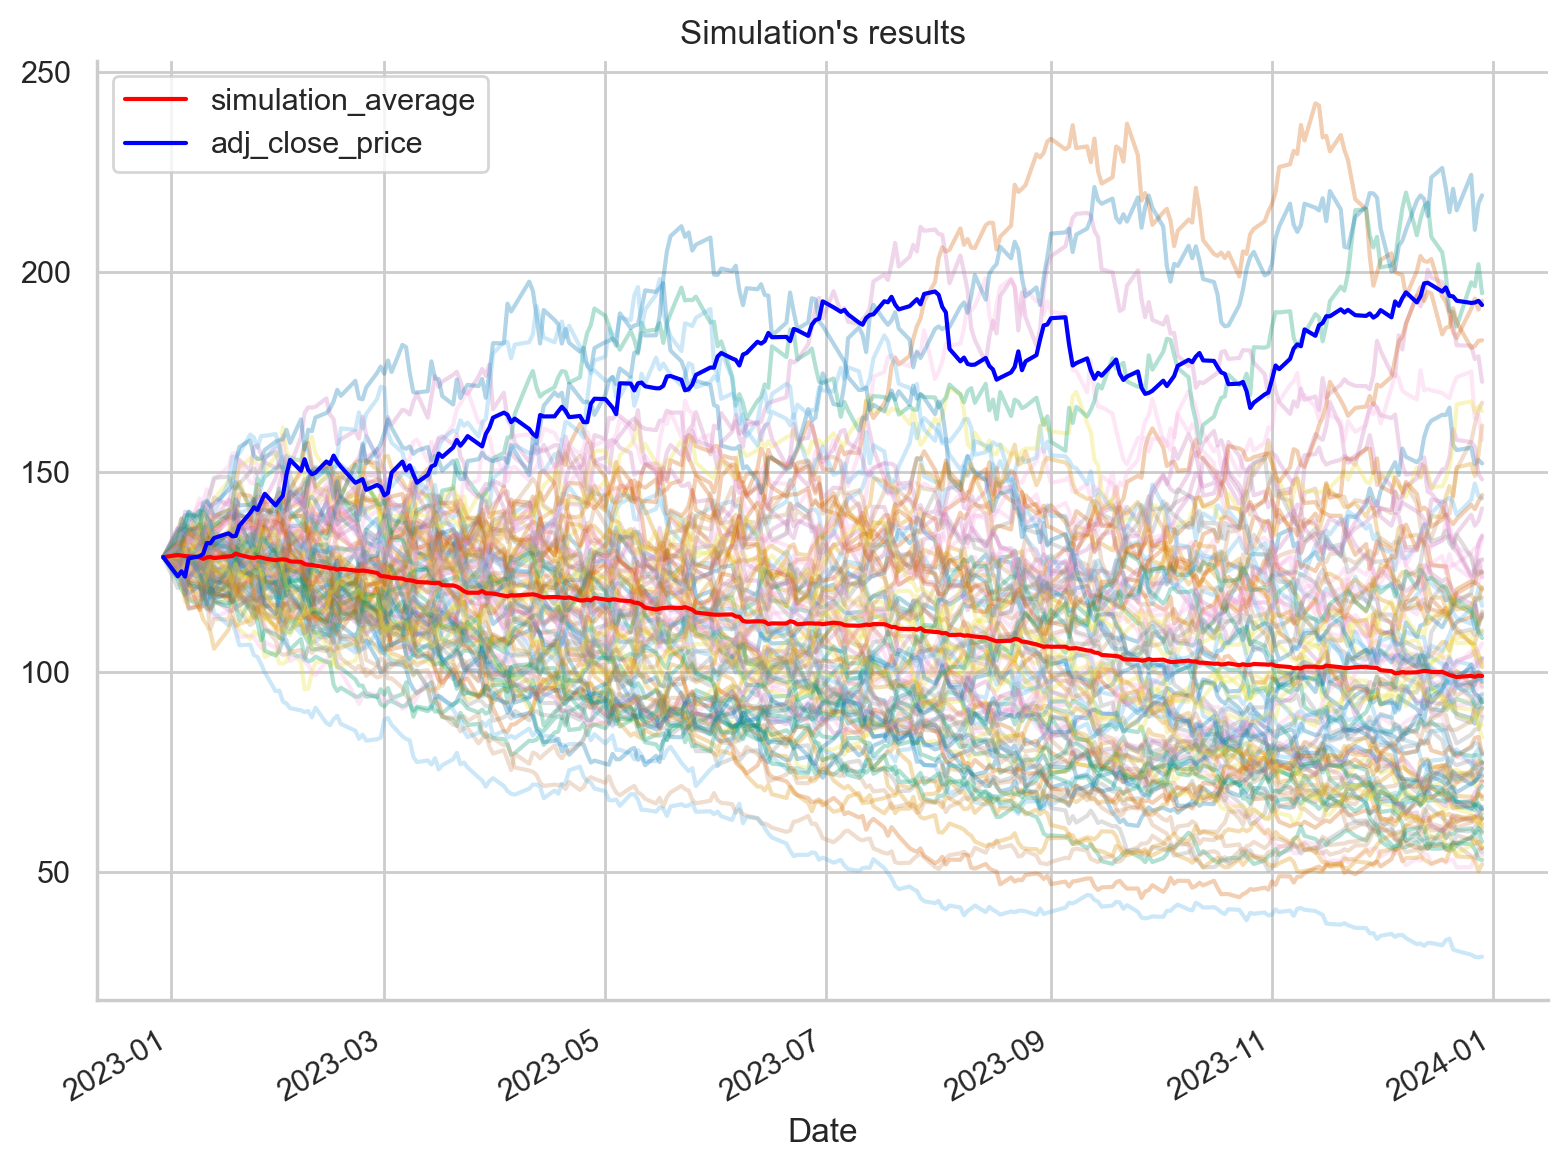

In [238]:
#plot the result of the simulation
ax = sim_df.plot(
    alpha=0.3, 
    legend=False, 
    title="Simulation's results"
)
res_df.plot(ax=ax, color = ["red", "blue"])

sns.despine()
plt.tight_layout()

In [242]:
%timeit gbm_simulations = simulate_geobrowmot(S_0, mu, sigma, N_SIM, T, N) #average execution time of the function

1.85 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [244]:
#using antithetic variable to reduce variance in simulations
def simulate_geobrowmot02(s_0,mu,sigma,n_sims,T,N,random_seed=42,antithetic_var=False):
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    if antithetic_var:
        dW_ant = np.random.normal(scale=np.sqrt(dt),size=(int(n_sims/2), N + 1)) #if antithetic variable is true, then reduce simulations by half
        dW = np.concatenate((dW_ant, -dW_ant), axis=0) #combine with negatives to form the complete set of antithetic variates
    else:
        dW = np.random.normal(scale=np.sqrt(dt),size=(n_sims, N + 1))
    
    #simulating the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, axis=1))
    S_t[:,0] = s_0
    return S_t
    

In [246]:
%timeit gbm_simulations = simulate_geobrowmot02(S_0, mu, sigma, N_SIM, T, N)

1.62 ms ± 34.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [248]:
%timeit gbm_simulations = simulate_geobrowmot02(S_0, mu, sigma, N_SIM, T, N,antithetic_var=True) #reduced the execution time and the variance of the function

1.14 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Pricing European Options using simulation

In [250]:
#defining parameters for valuation
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1
N = 252
dt = T/N
N_SIMS = 1_000_000
disc = np.exp(-r*T)

In [252]:
#valuing the option using the analytical function for non dividend paying stock
def blackscholes_analytical (S_0, K, T, r, sigma, type = "call"):
    """
    Function to value option using analytical form of Black Scholes Model
    S_0 : float, Initial stock price
    K : float, Exercise price
    T : float, Time to maturity
    r : float, risk free rate
    sigma : float, standard deviation of stock returns
    type : str, type of option
    option_premium = float, value of option premium arrived at using the BSM
    """
    d1 = (np.log(S_0/K) + (r+0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        N_d1 = norm.cdf(d1, 0, 1)
        N_d2 = norm.cdf(d2, 0, 1)
        val = S_0 * N_d1 - K * np.exp(-r * T) * N_d2
    elif type == "put":
        N_d1 = norm.cdf(-d1, 0, 1)
        N_d2 = norm.cdf(-d2, 0, 1)
        val = K * np.exp(-r * T) * N_d2 - S_0 * N_d1
    else:
        raise ValueError("Wrong input")

    return val
    

In [254]:
# value the option
print ("Option price using analytical method")
print ("Call price: ",blackscholes_analytical(S_0=S_0, K=K, T=T,r=r, sigma=sigma,type="call"))
#print ("Put price: ",blackscholes_analytical(S_0=S_0, K=K, T=T,r=r, sigma=sigma,type="put"))

Option price using analytical method
Call price:  21.79260421286685


In [256]:
#Simulate the stock path
gbm_sims = simulate_geobrowmot(s_0=S_0,mu=r,sigma=sigma,n_sims=N_SIMS,T=T,N=N,random_seed=42)

In [258]:
#calculate the option premium
print ("European Option price using GBM")
call_premium = (disc * np.mean(np.maximum(0, gbm_sims[:, -1] - K)))
print (f'Call price is {call_premium}')
#put_premium = (disc * np.mean(np.maximum(0, K - gbm_sims[:, -1])))
#print (f'Put price is {put_premium}')

European Option price using GBM
Call price is 21.731937527394578


Pricing American Options using Monte Carlo simulation

In [260]:
#defining the parameters
S_0 = 229 #current Apple Stock price
K = 230
r = 0.06
sigma = 0.2
T = 1
N = 50
dt = T/N
N_SIMS = 10 ** 5
disc = np.exp(-r*dt)
option_type = "call"
poly_degree = 5 #degree of the equation to be used in the regression

In [262]:
#simulate the stock prices using GBM
gbm_sims = simulate_geobrowmot(s_0=S_0,mu=r,sigma=sigma,n_sims=N_SIMS,T=T,N=N,random_seed=42)

In [264]:
#calculate the payoff matrix
if option_type =="put":
    payoff_matrix = np.maximum(K-gbm_sims,np.zeros_like(gbm_sims))
else:
    payoff_matrix = np.maximum(gbm_sims-K,np.zeros_like(gbm_sims))


In [266]:
#define the value matrix and fill in the last column
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1] #setting starting point for backward induction

In [268]:
#iteratively calculate the continuation value and value vector in given time
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * disc, 
                            poly_degree) #running a polynomial regression between the asset price at 't' and dependent variable being at t+1
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * disc
    )

In [270]:
#calculate the option premium
option_premium_am = np.mean(value_matrix[:, 1] * disc)
print ("Value of American Call option: ",option_premium_am)

option_premium_eu = blackscholes_analytical (S_0=S_0, K=K, T=T, r=r, sigma=sigma, type = "put")
print ("Value of European Call option: ",option_premium_eu)


Value of American Call option:  23.622991629127235
Value of European Call option:  12.230404290890618


Pricing American Options using Quantlib

In [272]:
#defining the parameters
S_0 = 229 #current Apple Stock price
K = 250
r = 0.06
sigma = 0.2
N = 50
dt = T/N
N_SIMS = 10 ** 5
disc = np.exp(-r*dt)
option_type = "put"
poly_degree = 5 #degree of the equation to be used in the regression

In [32]:
!pip install QuantLib-Python

In [274]:
import QuantLib as ql

In [276]:
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

In [278]:
#specifying the valuation data and expiry date
valuation_date = ql.Date(1, 1, 2022)
expiry_date =  ql.Date(1, 1, 2023)
ql.Settings.instance().evaluationDate = valuation_date

T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

Time to expiry in years: 1.0


In [280]:
#defining the option type, type of exercise and the payoff
if option_type == "call":
    option_type_ql = ql.Option.Call #setting variable to Call option in QL
elif option_type == "put":
    option_type_ql = ql.Option.Put
exercise = ql.AmericanExercise(valuation_date, expiry_date) #storing the instance of type of exercise
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

In [282]:
#preparing the market data
u = ql.SimpleQuote(S_0) 
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

In [284]:
#specifying market related curves
underlying = ql.QuoteHandle(u) #create a smart pointer
#setting up a volatility term structure with constant volatility
volatility = ql.BlackConstantVol(0, ql.TARGET(),ql.QuoteHandle(sigma),day_counter)
#setting up a constant interest rate term structure
risk_free_rate = ql.FlatForward(0, ql.TARGET(),ql.QuoteHandle(r),day_counter)

In [286]:
#plugging in market data in Black Scholes process
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

In [288]:
#instantiate the Monte Carlo engine for American Options
#this engine will help price American Options using a Monte Carlo simulation
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=poly_degree, 
                             seedCalibration=42, 
                             requiredSamples=N_SIMS)

In [290]:
#instantiating the option and set its pricing engine
#pricing engine handles the actual computation of the option's value
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

In [292]:
#calculating the option price
option_premium_ql = option.NPV()
print(f'The value of the American {option_type} option is: {option_premium_ql:.3f}')

The value of the American put option is: 25.085
